In [1]:
import os,sys,torch
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
from melanoma.data.dataset import SIIMDataset
from melanoma.config import TRAIN_CSV, IMAGE_DIR, TEST_CSV
dataset = SIIMDataset(IMAGE_DIR, TRAIN_CSV)
import albumentations as A

In [3]:
def strong_aug(p=0.5):
    return A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=0.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),
        ], p=0.2),
        A.ToFloat(max_value=255)
    ], p=p)


In [4]:
def heavy_transform_1(image_size=600, always_apply=False):
    tile_h, tile_w = image_size, image_size
    crop_min, crop_max = image_size // 2, image_size

    curve_p = 0.5
    blur_p = 0.5
    flip_p = 0.5
    grid_p = 0.5

    curve_transform = A.OneOf([
        #A.CLAHE(clip_limit=2, tile_grid_size=(8, 8), p=curve_p, always_apply=always_apply),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=curve_p, always_apply=always_apply),
        A.RandomGamma(gamma_limit=(30, 100), p=curve_p, always_apply=always_apply),
    ], p=curve_p)

    blur_transform = A.OneOf([
        A.Blur(blur_limit=5, p=blur_p, always_apply=always_apply),
        A.MedianBlur(blur_limit=3, p=blur_p, always_apply=always_apply),
    ], p=blur_p)

    grid_transform = A.OneOf([
        A.ElasticTransform(p=grid_p, alpha=80, sigma=50, alpha_affine=50, always_apply=always_apply),
        A.GridDistortion(p=grid_p, num_steps=9, border_mode=5, always_apply=always_apply),
        A.OpticalDistortion(p=grid_p, distort_limit=0.2, shift_limit=0.2)
    ], p=grid_p)

    transform = A.Compose([
        A.SmallestMaxSize(max_size=image_size),
        A.RandomCrop(image_size,image_size),
        curve_transform,
        blur_transform,
        A.HorizontalFlip(always_apply=always_apply, p=flip_p),
        A.VerticalFlip(always_apply=always_apply, p=flip_p),
        A.RandomRotate90(always_apply=always_apply, p=flip_p),
        A.Rotate(limit=15, always_apply=always_apply, p=flip_p),
        grid_transform,
        #A.PadIfNeeded(600, 1024, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #A.RandomSizedCrop(p=crop_p, min_max_height=(crop_min, crop_max), height=image_size, width=image_size, always_apply=always_apply),
        #A.CenterCrop(300, 300, always_apply=always_apply, p=1.0),
        A.GaussNoise(var_limit=(1, 50), p=0.4),
        A.ToFloat(max_value=255)
    ], p=1.0)

    return transform

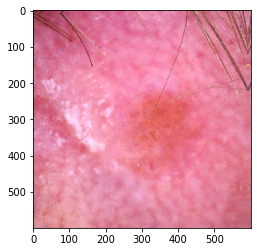

(600, 900, 3) uint8 /mnt/fastdata/kaggle/siim-isic-melanoma-classification/jpeg/train/ISIC_2637011_small.jpg


In [5]:
elem = dataset[0]
img = cv2.cvtColor(elem['image'], cv2.COLOR_BGR2RGB)
#aug = strong_aug(p=1)
aug = heavy_transform_1(always_apply=False)
#img = A.HorizontalFlip().apply(img)
plt.imshow(aug(image=img)['image'])
plt.show()
print(img.shape, img.dtype, elem['path'])



(600, 900, 3)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)
torch.Size([3, 600, 600]) tensor(1.)


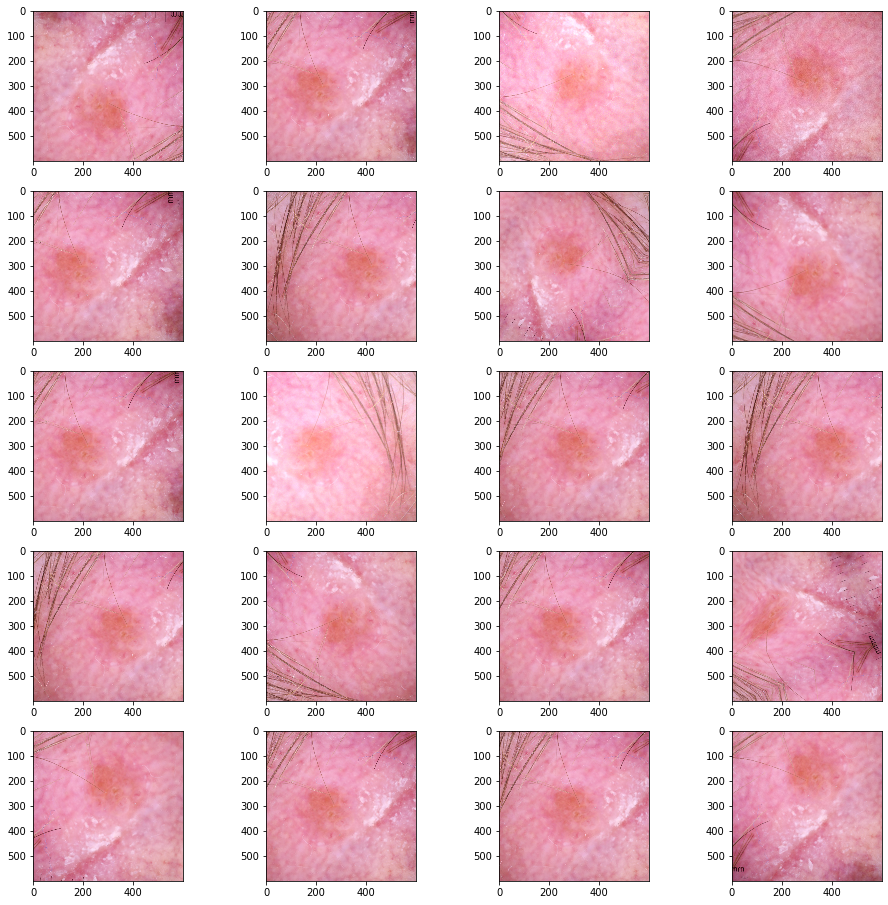

In [6]:
from melanoma.data.transform import factory

elem = dataset[0]
img = cv2.cvtColor(elem['image'], cv2.COLOR_BGR2RGB)
print(img.shape)
aug = factory('medium_1', 600, without_norm=True)[0]
#aug = strong_aug(p=1)

w, h = 40, 40
columns, rows = 4, 5
fig=plt.figure(figsize=(16, 16))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    new_img = aug(image=img)['image']
    #new_img = aug(img)
    plt.imshow(new_img.permute(1, 2, 0).numpy())
    #print(new_img.shape, np.max(new_img))
    print(new_img.size(), torch.max(new_img))
plt.show()

In [8]:
print('Start')
from melanoma.data.utils import Datasets

ll = Datasets(IMAGE_DIR, TRAIN_CSV, TEST_CSV, transform_name='heavy_1',
            image_size=300)
tr = ll.train_dataset

for i, elem in enumerate(tr):
    if elem['image'] is None:
        print(elem)
    if i % 1000 == 0:
        print(i, len(tr))




2020-06-02 02:08:45 Length of datasets train/val/test=26659/6467/10982


Start
TEST
0 26659
1000 26659
2000 26659
3000 26659
4000 26659
5000 26659
6000 26659
7000 26659
8000 26659
9000 26659
10000 26659
11000 26659
12000 26659
13000 26659
14000 26659
15000 26659
16000 26659
17000 26659
18000 26659
19000 26659
20000 26659
21000 26659
22000 26659
23000 26659
24000 26659
25000 26659
26000 26659
